In [1]:
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit import quantum_info
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile
from qiskit_ibm_runtime import Sampler

from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit.transpiler.passes import SabreLayout, SabreSwap
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.visualization import plot_histogram

In [2]:
n = 2
qc = QuantumCircuit(n)

for i in range(n):
    qc.h(i)

In [3]:
sv = quantum_info.Statevector(qc)
sv.draw('latex')

<IPython.core.display.Latex object>

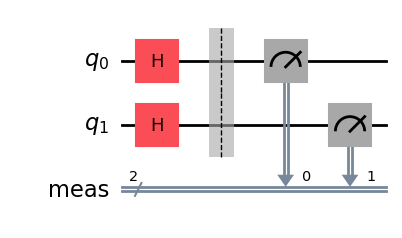

In [4]:
qc.measure_all()
qc.draw('mpl')

In [83]:
backend_aer = AerSimulator()

transpile_qc_aer = transpile(qc, backend=backend_aer, optimization_level=2)
sampler_aer = Sampler(backend_aer)

job_aer = sampler_aer.run([(transpile_qc_aer,None,500)])
# counts_aer = job_aer.result()[0].data.meas.get_counts()

result_aer = job_aer.result()[0].data.meas.get_counts()


PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=500, num_bits=2>)), metadata={'shots': 500, 'circuit_metadata': {}})], metadata={'version': 2})

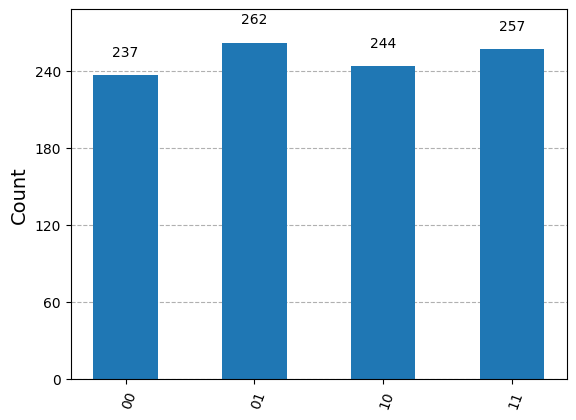

In [146]:
job_aer = sampler_aer.run([(transpile_qc_aer,None,1000)])
result_aer = job_aer.result()[0].data.meas.get_counts()
# I = job_aer.result()[0].data.meas.get_counts().keys()
# n = int(list(I)[0], 2)
# n

from qiskit.visualization import plot_histogram

plot_histogram(result_aer)

In [6]:
service = QiskitRuntimeService(channel = "ibm_quantum", # ibm_cloud
                               token = "444eec52519bcaafe4eb447aaad3d0aacb35e281d21caaacff75db8fafab05d8786a9adb51627c85085a6ab22cb44b683d11a8cede0e1b695a26b2cfb7d1d786")
backend = service.least_busy(simulator=False, operational=True)

In [7]:
transpile_qc = transpile(qc, backend=backend, optimization_level=2)

In [86]:
sampler = Sampler(backend)

job = sampler.run([(transpile_qc,None,12345)])
print(job.job_id())

cw978naggr6g0087rx7g


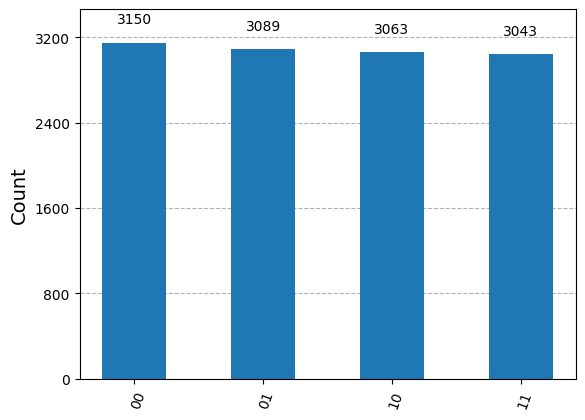

In [16]:
job_id = 'cw978naggr6g0087rx7g'
job = service.job(job_id)

counts = job.result()[0].data.meas.get_counts()

plot_histogram(counts)

In [91]:
import numpy as np

np.std(list(counts.values()))

np.float64(40.25776322648838)

In [8]:
# Step 2: Get the least busy operational backend
backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend.name()}")

# Step 3: Create a quantum circuit
n = 2  # Number of qubits
qc = QuantumCircuit(n)

# Apply Hadamard gates to both qubits
for i in range(n):
    qc.h(i)

# Measure the qubits
qc.measure_all()

# Step 4: Transpile the circuit for the chosen backend
transpile_qc = transpile(qc, backend=backend, optimization_level=2)

# Step 5: Create a noise model for simulation (for demonstration)
noise_model = NoiseModel()
depol_error = depolarizing_error(0.1, 1)  # 10% depolarizing error per qubit
noise_model.add_all_qubit_quantum_error(depol_error, ['h'])  # Apply to Hadamard gates

# Step 6: Run the circuit with a sampler (without noise for calibration)
sampler = Sampler(backend)
job = sampler.run([(transpile_qc, None, 12345)])
print(f"Job ID: {job.job_id()}")

# Step 7: Retrieve results using the job ID
job_id = job.job_id()  # Replace with a known job ID if needed
job = service.job(job_id)

# Get the measurement counts from the job result
counts = job.result()[0].data.meas.get_counts()

# Step 8: Implement Readout Error Correction
# Example calibration matrix (this should be obtained through experiments)
calibration_matrix = np.array([[0.9, 0.1], [0.1, 0.9]])  # Example values
corrected_counts = {}
for key, count in counts.items():
    if key[0] == '0':
        corrected_key = '0' if np.random.rand() < calibration_matrix[0, 0] else '1'
    else:
        corrected_key = '1' if np.random.rand() < calibration_matrix[1, 1] else '0'
    corrected_counts[corrected_key] = corrected_counts.get(corrected_key, 0) + count

# Step 9: Zero-Noise Extrapolation (for demonstration purposes)
# Run the circuit multiple times with varying noise levels (0%, 5%, 10%, etc.)
# Here we use simulated noise and vary the noise level manually.
zne_results = []
for noise_level in [0.0, 0.05, 0.1]:  # Example noise levels
    noisy_sim = AerSimulator(noise_model=noise_model)  # Simulate with noise
    noisy_counts = noisy_sim.run(transpile_qc).result().get_counts()
    zne_results.append(noisy_counts)

# Step 10: Extrapolate results to infer noiseless results (for illustration)
# A simple linear extrapolation might look like this:
def extrapolate_zero_noise(zne_results):
    # Assuming ZNE gives results in order of noise levels (low to high)
    total_counts = {key: sum(result.get(key, 0) for result in zne_results) for key in zne_results[0].keys()}
    return total_counts

extrapolated_counts = extrapolate_zero_noise(zne_results)

# Step 11: Visualize results
# Original counts with Readout Error Correction
print("Corrected Counts:", corrected_counts)
plot_histogram(corrected_counts)
plt.title("Counts After Readout Error Correction")
plt.show()

# Extrapolated counts
print("Extrapolated Counts:", extrapolated_counts)
plot_histogram(extrapolated_counts)
plt.title("Counts After Zero-Noise Extrapolation")
plt.show()


TranspilerError: 'More virtual qubits exist than physical.'

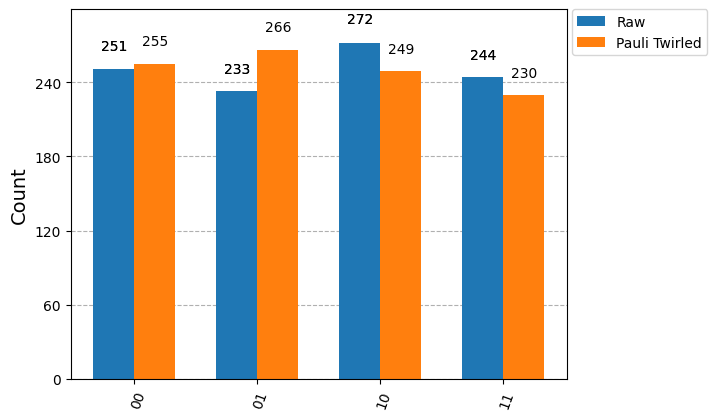

In [22]:
# Create a 2-qubit circuit (or use your circuit)
n = 2
qc = QuantumCircuit(n)
for i in range(n):
    qc.h(i)
qc.measure_all()

# Step 1: Create a noise model with depolarizing errors
noise_model = NoiseModel()

# Add depolarizing error to all single-qubit gates (like Hadamard in this case)
depol_error = depolarizing_error(0.01, 1)
noise_model.add_all_qubit_quantum_error(depol_error, ['h'])  # Adding noise to Hadamard gate

# Define the AerSimulator backend
backend_aer = AerSimulator()

# Transpile the circuit for the backend
transpile_qc_aer = transpile(qc, backend=backend_aer)

# Step 2: Transpile the circuit and run it with the noise model
job_aer = backend_aer.run(transpile_qc_aer, shots=1000, noise_model=noise_model)
result_aer = job_aer.result()
counts_aer = result_aer.get_counts()

# Step 3: Implement randomized Pauli gates (simulating twirling)
# You can apply random Pauli gates before and after the noisy gates
# This step simulates Pauli twirling by randomizing errors

# For simplicity, simulate a second transpile pass
pass_manager = PassManager()
twirled_qc = pass_manager.run(transpile_qc_aer)

# Step 4: Run the twirled circuit with noise model
job_twirled = backend_aer.run(twirled_qc, shots=1000, noise_model=noise_model)
result_twirled = job_twirled.result()
twirled_counts = result_twirled.get_counts()

# Step 5: Plot the results
plot_histogram([counts_aer, twirled_counts], legend=['Raw', 'Pauli Twirled'])
